## Ridge regression using the ridge sklearn model and sklearn cross-validation

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import RidgeCV

In [130]:
dataset = pd.read_csv("body_fat_data.csv", index_col=0)

### Features and their prefix equivalent, used for plotting graphs

In [131]:
features = ['Neck circumference (cm)','Chest circumference (cm)','Abdomen circumference (cm)', 'Hip circumference (cm)',
        'Thigh circumference (cm)', 'Knee circumference (cm)', 'Ankle circumference (cm)',
        'Extended biceps circumference (cm)', 'Forearm circumference (cm)', 
            'Wrist circumference (cm)','Age', 'Weight (lbs)',
            'Height (inches)']
features_short = ['Neck','Chest','Abdomen', 'Hip',
        'Thigh', 'Knee', 'Ankle ',
        'Extended biceps', 'Forearm', 
            'Wrist', 'Age', 'Weight (lbs)',
            'Height (inches)']
target = 'Percent body fat using Siri equation 495/Density'

In [132]:
def to_std(data, mean, std):
    
    return (data - mean) / std

In [133]:
train, test = train_test_split(dataset, test_size=0.33, random_state=1)

train.describe()

,Percent body fat using Siri equation 495/Density,Density gm/cm^3,Age,Weight (lbs),Height (inches),Adiposity index = Weight/Height^2 (kg/m^2),"Fat Free Weight (1 - fraction of body fat) * Weight, using Brozek formula (lbs)",Neck circumference (cm),Chest circumference (cm),Abdomen circumference (cm),Hip circumference (cm),Thigh circumference (cm),Knee circumference (cm),Ankle circumference (cm),Extended biceps circumference (cm),Forearm circumference (cm),Wrist circumference (cm)
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,18.994048,1.055817,44.720238,177.323214,70.053571,25.231548,142.989881,37.961310,100.194643,91.944048,99.618452,59.279167,38.470833,23.057143,32.196429,28.656548,18.173214
std,8.098242,0.018204,12.691610,25.441979,4.061756,3.133652,16.745333,2.192801,7.666736,9.747560,6.176463,4.688064,2.275102,1.508323,2.767409,1.948365,0.810668
min,3.000000,0.995000,22.000000,127.500000,29.500000,19.700000,105.900000,31.100000,83.400000,70.400000,85.300000,49.300000,33.400000,20.100000,25.600000,21.000000,16.300000
25%,12.175000,1.041550,35.000000,159.000000,68.250000,23.100000,130.650000,36.400000,93.825000,84.250000,95.575000,56.075000,36.900000,22.075000,30.200000,27.300000,17.600000
50%,19.200000,1.054900,43.000000,174.125000,70.000000,24.800000,141.850000,37.900000,99.550000,90.800000,99.150000,58.900000,38.300000,22.700000,31.950000,28.600000,18.250000
75%,25.225000,1.071000,54.000000,195.250000,72.250000,26.975000,154.650000,39.325000,104.750000,98.875000,103.125000,62.200000,39.725000,23.800000,34.300000,30.000000,18.800000
max,47.500000,1.092600,72.000000,244.250000,77.500000,37.600000,195.100000,43.900000,121.600000,122.100000,115.500000,72.900000,46.000000,33.900000,38.500000,34.900000,20.200000


### Data preprocessing, splitting into  train and eval, then standardizing

In [134]:
train_x = train[features].copy()
train_y = train[[target]].copy()

test_x = test[features].copy()
test_y = test[[target]].copy()


mean = train_x.mean()
std = train_x.std()

test_x = to_std(test_x, mean, std)
train_x = to_std(train_x, mean, std)


### Cross-validation of $\lambda$

In [135]:
lmbdas = [i/2 for i in range(1,51)]
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
ridge = RidgeCV(alphas=lmbdas, cv=cv, scoring='neg_mean_squared_error')
# fit model
ridge.fit(train_x, train_y)
print('alpha: %f' % ridge.alpha_)


alpha: 0.500000


In [136]:
coef = pd.DataFrame(ridge.coef_.reshape(13,1), index=ridge.feature_names_in_)

coef

,0
Neck circumference (cm),-0.820126
Chest circumference (cm),-0.014691
Abdomen circumference (cm),8.283604
Hip circumference (cm),-0.682735
Thigh circumference (cm),1.454499
Knee circumference (cm),-0.688344
Ankle circumference (cm),-0.107045
Extended biceps circumference (cm),0.316835
Forearm circumference (cm),0.422947
Wrist circumference (cm),-1.210073


### Coefficients plot

<AxesSubplot:>

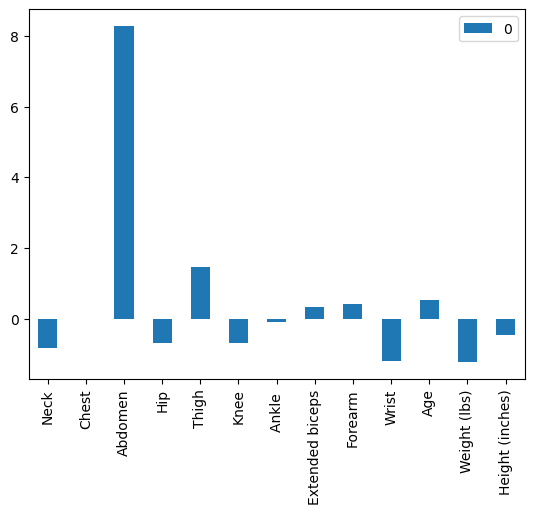

In [137]:
ridge.coef_

coefs = pd.DataFrame(ridge.coef_.T, index= features_short)

coefs.plot.bar()

### Compute prediction loss, using mean absolute error

In [138]:
pred= ridge.predict(test_x)

mse = mean_absolute_error(test_y, pred)

mse

3.5058283414082467

### Print the first five errors

In [143]:
pred = ridge.predict(test_x)
dif = 5
cnt = 0
for i,val in enumerate(pred):
    if (test_y.iloc[i].values[0] - val[0] > dif and  cnt < 5):
        cnt+=1
        print("Expected: " + str(test_y.iloc[i].values[0]) + " Actual: " + str(val[0]) + "  sample index: " + str(i))

Expected: 31.9 Actual: 26.098658112119956  sample index: 1
Expected: 17.4 Actual: 9.867943237611659  sample index: 14
Expected: 27.9 Actual: 20.143731310398554  sample index: 24
Expected: 33.6 Actual: 25.319057013237973  sample index: 26
Expected: 26.6 Actual: 17.557009510845663  sample index: 51


5

### Model performance  

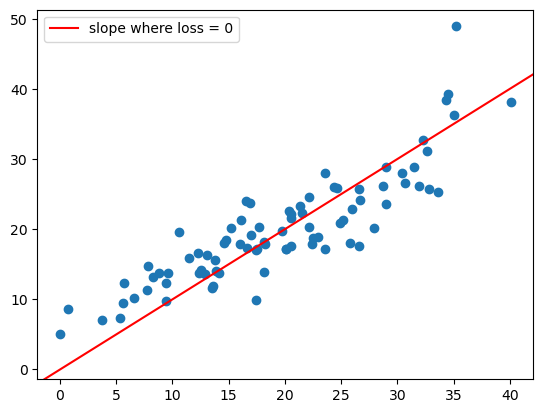

In [140]:
f, ax = plt.subplots(1)
ax.axline((1, 1), slope=1, c = 'red', label='slope where loss = 0')
plt.legend()
plt.scatter(test_y, pred)